In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# options used to build log files
models = ["a2c", "ppo", "dqn"]
skip_frames = ["1", "2", "4"]
observation_types = ["raw", "compressed"]
action_spaces = ["all"]

In [23]:
log_paths = []
for model in models:
    for skip_frame in skip_frames:
        for observation_type in observation_types:
            for action_space in action_spaces:
                log_paths.append(
                    f"logs/log_{model}_{skip_frame}_{observation_type}_{action_space}.csv"
                )
                
# remove log files that don't exist
log_paths = [log_path for log_path in log_paths if os.path.isfile(log_path)]

In [24]:
# create dfs from log files
titles = ["episode", "step", "episode_reward", "world", "level", "level_progress", "episode_length"]
dfs = [pd.read_csv(log_path, names=titles) for log_path in log_paths]

In [45]:
# bin dfs
binned_dfs = []
for df in dfs:
    max_step = max(df['step'])
    bin_constant = max_step // 50 # adjust this to affect bin sizes
    bins = range(0, bin_constant * (max_step // bin_constant) + bin_constant, bin_constant)

    binned_df = df.groupby(pd.cut(df['step'], bins=bins))['episode_reward'].mean().reset_index()
    binned_df['step'] = binned_df['step'].map(lambda x: x.mid)
    binned_dfs.append(binned_df)

/var/folders/7q/rl5mb6fs5xq7sxwq0b4nh8bc0000gn/T/ipykernel_15122/950792947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = df.groupby(pd.cut(df['step'], bins=bins))['episode_reward'].mean().reset_index()
/var/folders/7q/rl5mb6fs5xq7sxwq0b4nh8bc0000gn/T/ipykernel_15122/950792947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = df.groupby(pd.cut(df['step'], bins=bins))['episode_reward'].mean().reset_index()
/var/folders/7q/rl5mb6fs5xq7sxwq0b4nh8bc0000gn/T/ipykernel_15122/950792947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

<Axes: xlabel='step', ylabel='episode_reward'>

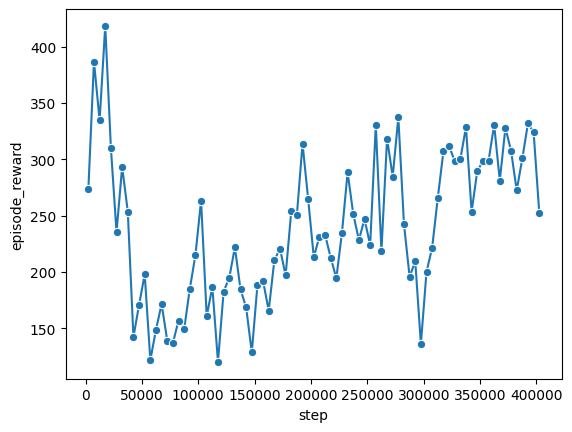

In [13]:
sns.lineplot(x='step', y='episode_reward', data=binned_df, marker='o')

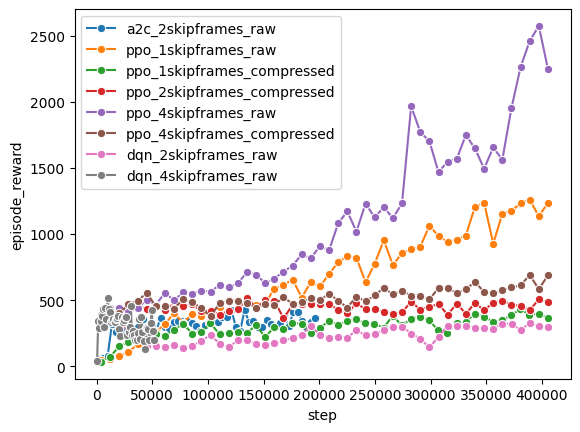

In [47]:
# plot training curves on 1 graph
for i, binned_df in enumerate(binned_dfs):
    filename = log_paths[i].split('_')[1:] # remove log_
    filename[1] = filename[1] + 'skipframes'
    filename = '_'.join(filename[:-1]) # remove action_space and .csv
    if filename == 'ppo_2skipframes_raw':
        # this one is trained for more iterations and so looks weird on the graph
        continue
    sns.lineplot(x='step', y='episode_reward', data=binned_df, marker='o', label=filename)

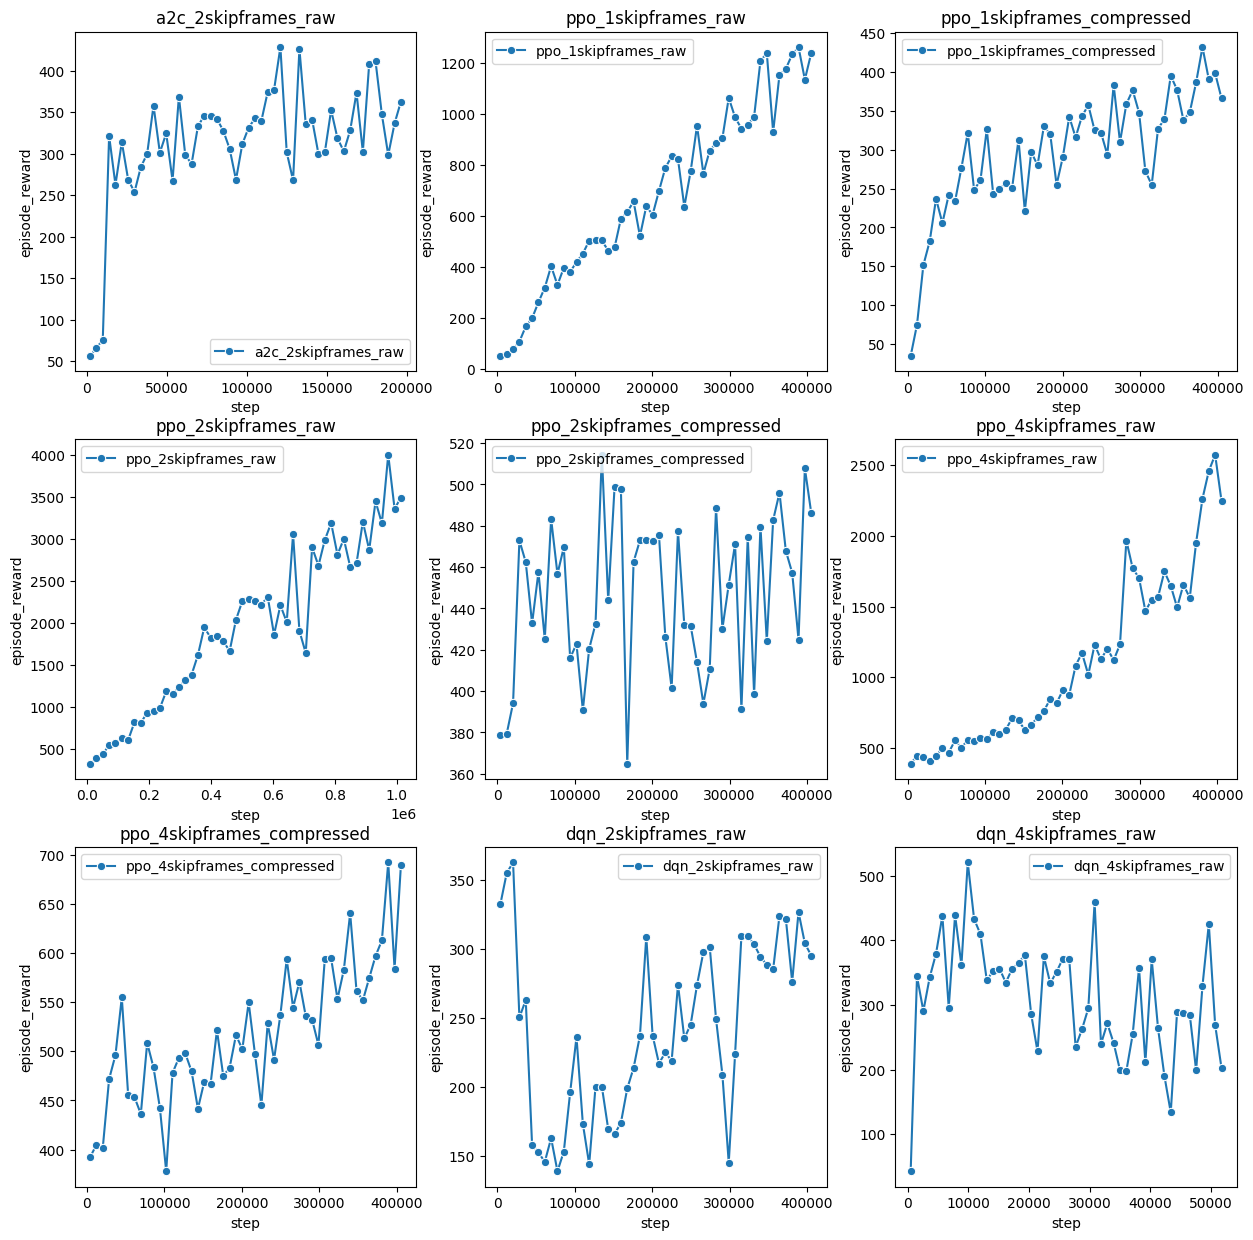

In [46]:
# generate 3x3 grid of training curves
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, binned_df in enumerate(binned_dfs):
    filename = log_paths[i].split('_')[1:] # remove log_
    filename[1] = filename[1] + 'skipframes'
    filename = '_'.join(filename[:-1]) # remove action_space and .csv

    row = i // 3
    col = i % 3
    sns.lineplot(x='step', y='episode_reward', data=binned_df, marker='o', label=filename, ax=axs[row][col])
    axs[row][col].set_title(filename)
    axs[row][col].set_xlabel('step')
    axs[row][col].set_ylabel('episode_reward')